In [39]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [2]:
def carregar_dados(diretorio):
    rna = [str(info.seq) for info in SeqIO.parse(diretorio, "fasta")]
    rna = list(map(" ".join,rna))
    classes = [info.id.split("-")[-1].split(".")[0] for info in SeqIO.parse(diretorio, "fasta")]
    return rna,classes

In [3]:
def codificar_sequencias(array, classes_array, encoder_type):
    encoder_type.fit(classes_array)
    encoded_proteins = []
    for n in range(array.shape[0]):
        encoded_proteins.append(list(encoder_type.transform(array[n][0].split(" "))))
    return encoded_proteins


In [131]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

# rRNA 16S

In [36]:
#Importar sequencias
rna,classes = carregar_dados("/home/tiago/documents/projeto_iam/dataset16s.fasta")


In [92]:
features = pd.DataFrame({
    "RNA":rna,
    "Classes":classes
})
classes_count = features.Classes.value_counts()
classes_manter = list(classes_count[classes_count > 1].index)
features = features.query("Classes == @classes_manter")
features = features.query("Classes != 'Other'")
features = features.query("Classes != 'Hydrogenophilalia'")
features = features.query("Classes != 'Zetaproteobacteria'")
rna = features.RNA.values
classes = features.Classes.values

In [94]:
#Codificar sequencias de RNA em vetores númericos
nucleotideos = list("ATCGRNSYKWM")
codificador_de_sequencias = LabelEncoder()
rnas_codificados = codificar_sequencias(np.array(rna).reshape(-1,1),nucleotideos,codificador_de_sequencias)
rna_mais_longo = sorted(list(map(len,list(rna))))[-1]
rnas_padded = pad_sequences(rnas_codificados, maxlen = rna_mais_longo, padding='post', value = 15).astype("float32")
#Codificaar classes em números inteiros
conjunto_de_classes = list(set(classes))
codificador_de_classes = LabelEncoder()
codificador_de_classes.fit(conjunto_de_classes)
classes_codificadas = codificador_de_classes.transform(classes).reshape(-1,1).astype("float32")
print(rnas_padded.shape,classes_codificadas.shape)
#Holdout
X_treino16,X_teste16,y_treino16,y_teste16 = train_test_split(rnas_padded, classes_codificadas, train_size = 0.7, random_state = 42,stratify = classes_codificadas)
print(X_treino16.shape,X_teste16.shape,y_treino16.shape,y_teste16.shape)

(5888, 4685) (5888, 1)
(4121, 4685) (1767, 4685) (4121, 1) (1767, 1)


In [132]:
modelo_classificador16 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = 14+2,output_dim = 8,input_length=rna_mais_longo),
    tf.keras.layers.Conv1D(filters = 64,kernel_size = 24),
    tf.keras.layers.MaxPooling1D(pool_size = 8),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 32,kernel_size = 12),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 16,kernel_size = 6),
    tf.keras.layers.MaxPooling1D(pool_size = 2),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 8,kernel_size = 4),
    tf.keras.layers.MaxPooling1D(pool_size = 1),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(len(conjunto_de_classes),activation = "softmax")
    ])
modelo_classificador16.compile(
    optimizer = tf.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
        auroc
    ]
)

In [ ]:
treinador_16s = modelo_classificador16.fit(
    X_treino16,
    y_treino16,
    validation_data = (X_teste16,y_teste16),
    epochs = 50,
    verbose = 0)

In [100]:
modelo_classificador16.save("Modelo_16S")

INFO:tensorflow:Assets written to: Modelo_16S/assets


In [139]:
modelo_classificador16.predict(X_teste16).shape

(1767, 36)

In [140]:
roc_auc_score(y_teste16,modelo_classificador16.predict(X_teste16), multi_class = "ovr", average = "macro")

0.5520960368951615

# rRNA 23S

In [143]:
#Importar sequencias
rna,classes = carregar_dados("/home/tiago/documents/projeto_iam/dataset23s.fasta")

In [144]:
features = pd.DataFrame({
    "RNA":rna,
    "Classes":classes
})
classes_count = features.Classes.value_counts()
classes_manter = list(classes_count[classes_count > 1].index)
features = features.query("Classes == @classes_manter")
features = features.query("Classes != 'Other'")
features = features.query("Classes != 'Hydrogenophilalia'")
features = features.query("Classes != 'Zetaproteobacteria'")
rna = features.RNA.values
classes = features.Classes.values

In [153]:
#Codificar sequencias de RNA em vetores númericos
nucleotideos = list("ATCGRNSYKWMDV")
codificador_de_sequencias = LabelEncoder()
rnas_codificados = codificar_sequencias(np.array(rna).reshape(-1,1),nucleotideos,codificador_de_sequencias)
rna_mais_longo = sorted(list(map(len,list(rna))))[-1]
rnas_padded = pad_sequences(rnas_codificados, maxlen = rna_mais_longo, padding='post', value = 17).astype("float32")
#Codificaar classes em números inteiros
conjunto_de_classes = list(set(classes))
codificador_de_classes = LabelEncoder()
codificador_de_classes.fit(conjunto_de_classes)
classes_codificadas = codificador_de_classes.transform(classes).reshape(-1,1).astype("float32")
print(rnas_padded.shape,classes_codificadas.shape)
#Holdout
X_treino23,X_teste23,y_treino23,y_teste23 = train_test_split(rnas_padded, classes_codificadas, train_size = 0.7, random_state = 42, stratify = classes_codificadas)
print(X_treino23.shape,X_teste23.shape,y_treino23.shape,y_teste23.shape)

(5888, 11245) (5888, 1)
(4121, 11245) (1767, 11245) (4121, 1) (1767, 1)


In [154]:
modelo_classificador23s = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim =16+2,output_dim = 8,input_length=rna_mais_longo),
    tf.keras.layers.Conv1D(filters = 64,kernel_size = 24),
    tf.keras.layers.MaxPooling1D(pool_size = 8),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 32,kernel_size = 12),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 16,kernel_size = 6),
    tf.keras.layers.MaxPooling1D(pool_size = 2),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 8,kernel_size = 4),
    tf.keras.layers.MaxPooling1D(pool_size = 1),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(len(conjunto_de_classes),activation = "softmax")
    ])
modelo_classificador23s.compile(
    optimizer = tf.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
    ]
)

In [155]:
treinador_23s = modelo_classificador23s.fit(
    X_treino23,
    y_treino23,
    validation_data = (X_teste23,y_teste23),
    epochs = 50,
    verbose = 0)

In [158]:
modelo_classificador23s.save("Modelo_23S")

INFO:tensorflow:Assets written to: Modelo_23S/assets


In [159]:
modelo_classificador23s.predict(X_teste23).shape

(1767, 36)

In [160]:
y_teste23.shape

(1767, 1)

In [161]:
roc_auc_score(y_teste23,modelo_classificador23s.predict(X_teste23), multi_class = "ovr", average = "macro")

0.9880011696345606

# Gráficos

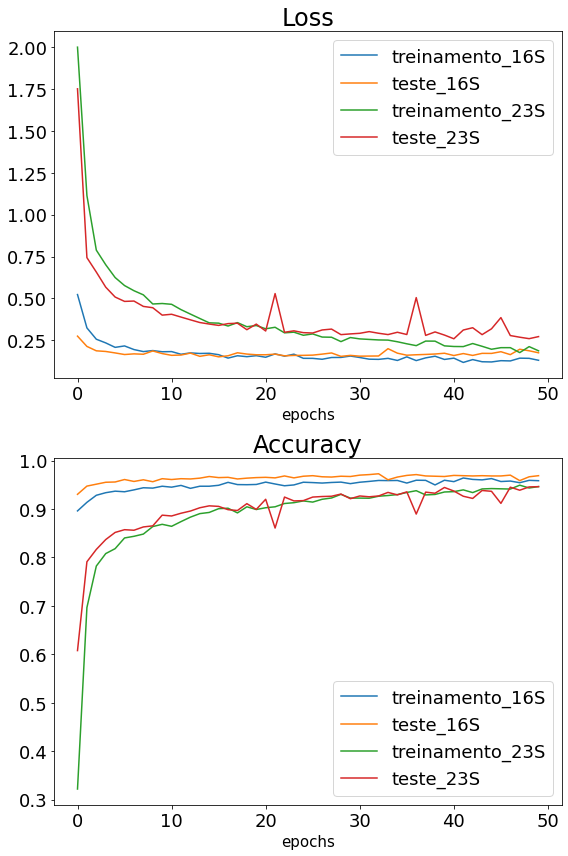

In [163]:
#Plot loss
plt.figure(figsize = (8,12))
plt.subplot(211)
plt.plot(treinador_16s.history['loss'], label='treinamento_16S')
plt.plot(treinador_16s.history['val_loss'], label='teste_16S')
plt.plot(treinador_23s.history['loss'], label='treinamento_23S')
plt.plot(treinador_23s.history['val_loss'], label='teste_23S')

plt.title('Loss', fontsize = 24)
plt.xticks(fontsize = 18)
plt.xlabel("epochs",fontsize = 15)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 18)
#Plot accuracy during training
plt.subplot(212)
plt.title('Accuracy',fontsize = 24)
plt.plot(treinador_16s.history['sparse_categorical_accuracy'], label='treinamento_16S')
plt.plot(treinador_16s.history['val_sparse_categorical_accuracy'], label='teste_16S')
plt.plot(treinador_23s.history['sparse_categorical_accuracy'], label='treinamento_23S')
plt.plot(treinador_23s.history['val_sparse_categorical_accuracy'], label='teste_23S')

plt.xlabel("epochs",fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 18)
plt.tight_layout()